# 영어 수화 알파벳 추론
- colab에서 학습한 모델을 이용해 추론

## Pre request
- tensorflow
- tensorflow object detection api2 ("tensorflow object detection api2 윈도우즈 설치.md" 파일 참고)
- pip install pyyaml

## 학습한 컴퓨터(colab)에서 가져올 것
- 학습한 weights: checkpoint 파일들
- pipeline.config
- Label Map 파일: label_map.pbtxt

# 경로 변수 설정

In [23]:
PIPELINE_CONFIG_PATH = 'config/pipeline.config'
LABELMAP_FILE_PATH = 'config/label_map.pbtxt'
CHECKPOINT_DIR_PATH = 'checkpoint'

# import

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

# 모델 생성 + weight restore

In [25]:
# pipeline.config loading
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)

# config를 이용해서 모델을 생성
detection_model = model_builder.build(model_config=configs['model'], is_training=False)
print(type(detection_model))

# 생성된 모델의 weight들을 학습한 weight들로 덮어쓰기
# 학습된 checkpoint(weight)를 loading
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_DIR_PATH, 'ckpt-51')).expect_partial()

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


# detection 함수 정의

In [26]:
def detect_function(image):
    # preprocessing
    images, shape = detection_model.preprocess(image)

    # predict
    pred = detection_model.predict(image, shape)

    # postprocess
    result = detection_model.postprocess(pred, shape)
    
    return result

# Label Map 파일 로딩

In [27]:
category_index = label_map_util.create_category_index_from_labelmap(LABELMAP_FILE_PATH)

In [28]:
category_index

{1: {'id': 1, 'name': 'A'},
 2: {'id': 2, 'name': 'B'},
 3: {'id': 3, 'name': 'C'},
 4: {'id': 4, 'name': 'D'},
 5: {'id': 5, 'name': 'E'},
 6: {'id': 6, 'name': 'F'},
 7: {'id': 7, 'name': 'G'},
 8: {'id': 8, 'name': 'H'},
 9: {'id': 9, 'name': 'I'},
 10: {'id': 10, 'name': 'J'},
 11: {'id': 11, 'name': 'K'},
 12: {'id': 12, 'name': 'L'},
 13: {'id': 13, 'name': 'M'},
 14: {'id': 14, 'name': 'N'},
 15: {'id': 15, 'name': 'O'},
 16: {'id': 16, 'name': 'P'},
 17: {'id': 17, 'name': 'Q'},
 18: {'id': 18, 'name': 'R'},
 19: {'id': 19, 'name': 'S'},
 20: {'id': 20, 'name': 'T'},
 21: {'id': 21, 'name': 'U'},
 22: {'id': 22, 'name': 'V'},
 23: {'id': 23, 'name': 'W'},
 24: {'id': 24, 'name': 'X'},
 25: {'id': 25, 'name': 'Y'},
 26: {'id': 26, 'name': 'Z'}}

# Image Detection 작업 처리
- 이미지 로딩
- 추론
- 추론 결과를 시각화

In [29]:
os.getcwd()

'c:\\Users\\ChangHo Kim\\Documents\\GitHub\\SSAC_study\\DL2_Object_detection\\sign_language_detection'

In [30]:
test_img = 'test_image/x.jpg'
img_np = cv2.cvtColor(cv2.imread(test_img), cv2.COLOR_BGR2RGB)
input_tensor = tf.convert_to_tensor(img_np[np.newaxis, ...], dtype=np.float32)
pred = detect_function(input_tensor)
type(pred)

dict

In [31]:
num_detections = int(pred.pop('num_detections'))
num_detections

100

In [32]:
detections = {key: value[0, :num_detections].numpy() for key, value in pred.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

In [36]:
detections['detection_classes']+1 # 1 ~ 26: 알파벳

array([17,  2, 16, 17, 16, 15, 17, 24,  6,  8, 19, 21, 10,  2, 11, 11, 16,
       15, 13, 13, 23, 10, 16, 16, 11, 23, 19, 26, 26,  6, 19, 25,  3,  2,
       17,  1,  3,  1, 10, 22, 22, 16, 19, 10, 19, 13,  1,  6,  8,  9, 22,
       26, 25, 10,  5,  1, 13, 21, 17,  3,  7,  8, 13, 10,  1, 14, 18, 18,
       19, 13, 12,  3,  7, 13, 19, 24, 20, 13, 26, 16, 16,  8, 10, 14,  1,
       23,  4, 26, 19, 20, 26, 16,  8,  7, 13, 24, 21, 26, 10, 13],
      dtype=int64)

In [33]:
# visualization
img = viz_utils.visualize_boxes_and_labels_on_image_array(
    img_np,
    detections['detection_boxes'],
    detections['detection_classes']+1,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=0.6
)

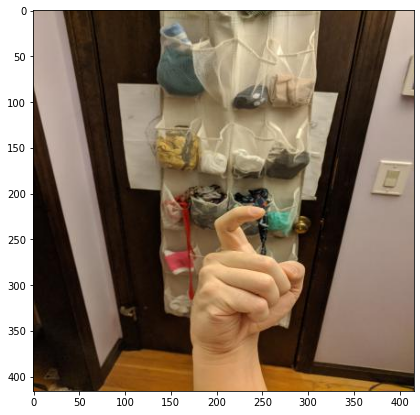

In [34]:
%matplotlib inline

plt.figure(figsize=(8, 7))
plt.imshow(img)
plt.show()

# 실시간 detection
- 웹캠(동영상)의 수화 동작을 detection 하도록 구현

In [39]:
cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     sys.exit(0)

while True:
    success, frame = cap.read()
    if not success:
        print('Fail capture')
        break
    
    # 좌우반전
    frame = cv2.flip(frame, 1)

    #===========================================#
    # detection                                 #
    # rgb변환 > tensor > predict > visualize    #
    #===========================================#
    img_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(img_np[np.newaxis, ...], dtype=tf.float32)
    pred = detect_function(input_tensor)

    num_detections = int(pred.pop('num_detections'))
    detections = {key:value[0, :num_detections].numpy() for key, value in pred.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    img = viz_utils.visualize_boxes_and_labels_on_image_array(
        frame, # bgr인 frame에 bounding box를 처리
        detections['detection_boxes'],
        detections['detection_classes']+1,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=5, # box 최대 5개 그리기
        min_score_thresh=0.6
    )

    cv2.imshow('img', img)
    if cv2.waitKey(1) == 27: # esc 클릭시
        break

cap.release()
cv2.destroyAllWindows()